In [2]:
from IPython.display import Image 
import random
import numpy as np
from sklearn.preprocessing import normalize
import timeit

# Spell checking using hidden markov models

Here is an example of a hidden markov model in which a user has typed a few words which are clearly mispelled.

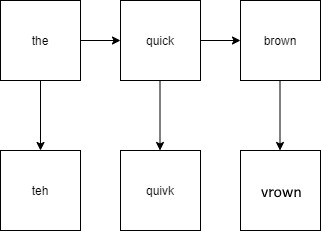

In [93]:
pil_img = Image(filename='images\\01.png')
display(pil_img)

The hidden variables $v_{1:T}$ are the correctly spelled words and the observed variables $h_{1:T}$ are the mispelled words.  This is a stationary model since transitions are not dependant on time.  In this situation the model will observe all observed variables and will attempt to discern the most likely state of each hidden variable.  This type of problem is called viterbi alignment or most likely hidden state and is the most common use of HMM.  Formally, $argmax_{(h_1:T)}p(h_{1:T}|v_{1:T})$.

Recall the equation for the overall distribution 
$$p(h_{1:T},v_{1:T}) = p(v_1|h_1)p(h_1)\prod_{t=2}^Tp(v_t|h_t)p(h_t|h_{t-1})$$
<br>
In adition the distribution for transition between hidden variables $p(h_{t+1}|h_t)$ is defined by the intial distribution of $p(h_1)$ and a transition matrix of dimension $HxH$ where H is the domain of hidden variables.  The transition matrix A is defined by $$A_{i',i}=p(h_{t+1}=i'|h_t=i)$$ with initial distribution $$a_i=p(h_1=i)$$
<br>
To define these joint and initial distributions we need an n-gram dataset, where n is the length of words in a phrase.  An n-gram dataset essentially shows the popularity of each possible phrase of length n.  The 1-gram set will give initial distributions, 2-gram gives $p(h_2|h_1)$, $p(h_3|h_2)$, ... $p(h_n|h_{n-1})$ and so on.  If this were a second-order markov chain, we would use 3-grams to estimate $p(h_n|h_{n-1}, h_{n-2}), ... p(h_n|h_{n-1},h_{n-2})$  
<br>Google provides a dataset constructed from scanning google books, but a user could create one easily by parsing books from gutenberg, splitting on sentences, and sorting n-gram phrases by occurrence.   Below I've shown how this would work it's actually quite simple.  I took 11 books from gutenberg.org

Note that I also built a dictionary of every word scanned.  This dictionary will contain a list of many valid English words.  More on that later.

In [3]:
nonwords = ['b','c','d','e','f','g','h','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
#use a set and a dictionary because these give an insane runtime
dictionary = set([])
bigram = {}
def constructNGramAndDict(book, dic,dictionary):
    #open the book
    with open(book, 'r',encoding="utf8") as file:
        #strip the punctuation and make an array for each sentence
        out = file.read().replace('\n', ' ')
        out = out.replace("“", " ")
        out = out.replace("”", " ")
        out = out.replace("\' ", " ")
        out = out.replace(" \'", " ")
        out = out.replace("_","")
        out = out.replace("?",".")
        out = out.replace("--",".")
        out = out.replace(",",".")
        out = out.replace("!",".")
        out = out.replace(";",".")
        out = out.replace(":",".")
        out = out.replace("...",".")
        data = out.split(".")
        #for each sentence
        for i in data:
            sentence = i.rstrip().lstrip().lower().split(" ")
            if len(sentence) > 1:
                #go through the sentence and add each two word phrase to the bigram
                #if the phrase already exists increment the count
                #and add each word to the dictionary
                for j in range(len(sentence)-1):
                    r = j
                    l = j+1
                    phrase = sentence[r]+" "+sentence[l]
                    if phrase in dic:
                        dic[phrase] += 1
                    else:
                        dic[phrase]= 1
                    if sentence[r] not in dictionary:
                        dictionary.add(sentence[r])
                if sentence[-1] not in dictionary:
                        dictionary.add(sentence[-1])
            else:
                if sentence[0] not in dictionary:
                        dictionary.add(sentence[-1])
#process books
start = timeit.default_timer()
constructNGramAndDict("books\\219-0.txt", bigram, dictionary)
constructNGramAndDict("books\\2021-0.txt", bigram, dictionary)
constructNGramAndDict("books\\1342-0.txt", bigram, dictionary)
constructNGramAndDict("books\\1058-0.txt", bigram, dictionary)
constructNGramAndDict("books\\236-0.txt", bigram, dictionary)
constructNGramAndDict("books\\120-0.txt", bigram, dictionary)
constructNGramAndDict("books\\pg164.txt", bigram, dictionary)
constructNGramAndDict("books\\pg18857.txt", bigram, dictionary)
constructNGramAndDict("books\\pg103.txt", bigram, dictionary)
constructNGramAndDict("books\\pg19033.txt", bigram, dictionary)
constructNGramAndDict("books\\36-0.txt", bigram, dictionary)
#remove the initials that get used in the books
for i in nonwords:
    if i in dictionary:
        dictionary.remove(i)
dictionary = set(dictionary)
stop = timeit.default_timer()
print("how long did it take to process the books?")
print('Runtime: ', stop - start)  
print("how many times is a common phrase in our bigram?")
print(bigram["and the"])
print("how many times is a rare phrase in our bigram?")
print(bigram["serenity became"]) 
print("does our dictionary contain a common word?")
print("the" in dictionary)
print("does our dictionary contain a rare word?")
print("MacGyver" in dictionary)

how long did it take to process the books?
Runtime:  1.8344590999999966
how many times is a common phrase in our bigram?
2006
how many times is a rare phrase in our bigram?
1
does our dictionary contain a common word?
True
does our dictionary contain a rare word?
False


And knowing that each phrase is mapped to a count, here's the expression:
$$p_{simple}(h_{i-1},h_{i}) = \frac{count(h_{i-1} + "\," + h_i)}{total \, count}$$
Where total count is the sum of each bi-gram count in transition $h_{i-1} \rightarrow h_{i}$. <br>

Continuing from above, The distribution for emission -- $p(v_t|h_t)$ -- is defined by a matrix of $VxH$ dimension.  The emission matrix B is defined by $$B_{i,j}=p(v_t=i|h_t=j)$$

To find the emission probabilities we need to design a system which attempts to emulate a user making typos on a qwerty keyboard.  For example, switching two neighboring letters, failing to press a key all the way down, hitting a nearby key before the intended one, and missing the key entirely and hitting a nearby one instead.  scramble(word) will introduce n iterations of noise to the word.  Each iteration is a less likely mispelling of the word.  

Note: there's a dp algorithm called edit distance that would do the same as Pdist but in a much better runtime.  However, the scramble idea will lead to a function called unscramble which I will use later.

In [4]:
#correct is a helper function
def correct(array,x,y):
    #if index in bounds return otherwise do nothing
    if y < len(array) and y >= 0:
        if x < len(array[y]) and x >= 0:
            return array[y][x]
#also a helper function for finding the first occurrence in a 2d array
def find(array,i):
    for j in range(len(array)):
        if i in array[j]:
            return j,array[j].index(i)
#this array portrays the layout of a keyboard
querty = [
    ['q','w','e','r','t','y','u','i','o','p'],
    ['a','s','d','f','g','h','j','k','l','\''],
    ['z','x','c','v','b','n','m'],
]
#find the neighbors of a key on the keyboard
def neighbors(letter):
    y,x = find(querty, letter)
    temp2 = [correct(querty,x,y+1),correct(querty,x,y-1),correct(querty,x+1,y),correct(querty,x-1,y),correct(querty,x+1,y+1),correct(querty,x+1,y-1),correct(querty,x-1,y+1),correct(querty,x-1,y-1)]
    nearby = []
    for index in temp2:
        if index != None:
            nearby.append(index)
    nearby.append(letter)
    return nearby

In [5]:
#this function illustrates generating possible typos from a valid word
def scramble(vocab,iterations):
    result = []
    for i in vocab:
        oldLevel = [i]
        result.append(oldLevel)
        newLevel = []
        #an "iteration" is a single keystroke of noise
        for j in range(iterations):
            for word in oldLevel:
                #there are four types of typos
                for type in range(4):
                    if type == 0:
                        #swap two neighboring letters
                        for pos1 in range(len(word)-1):
                            pos2 = pos1 + 1
                            stringList = list(word)
                            stringList[pos1],stringList[pos2]=stringList[pos2],stringList[pos1]
                            jumbled = "".join(stringList)
                            newLevel.append(jumbled)
                    if type == 1:
                        #replace with a letter that is close on the querty keyboard
                        for temp in range(0,len(word)):
                            nearby = neighbors(word[temp])
                            for letter in nearby:
                                stringList = list(word)
                                stringList[temp]=letter
                                jumbled = "".join(stringList)
                                newLevel.append(jumbled)
                    if type == 2:
                        #delete a letter
                        for temp in range(0,len(word)):
                            stringList = list(word)
                            jumbled = "".join(stringList[:temp]+stringList[temp+1:])
                            newLevel.append(jumbled)
                    if type == 3:
                        #insert a letter that is close on the querty keyboard to the letter after it
                        for temp in range(0,len(word)):
                            nearby = neighbors(word[temp])
                            for letter in nearby:
                                stringList = list(word)
                                jumbled = "".join(stringList[:temp]+[letter]+stringList[temp:])
                                newLevel.append(jumbled)
            oldLevel = newLevel
            newLevel = []
            result.append(oldLevel)
    return result

In [6]:
#scramble the word "it" with one iteration of noise
#return all the resulting typos
scramble(["it"],1)[1]

['ti',
 'kt',
 'ot',
 'ut',
 'lt',
 'jt',
 'it',
 'ig',
 'iy',
 'ir',
 'ih',
 'if',
 'it',
 't',
 'i',
 'kit',
 'oit',
 'uit',
 'lit',
 'jit',
 'iit',
 'igt',
 'iyt',
 'irt',
 'iht',
 'ift',
 'itt']

Then, I define a Pdist function, which takes edit distances and generates a normalized probability distribution.

In [7]:
#this function takes a word and it's typo and returns the probability that the word "emitted" the typo
def p_dist(correct, typo):
    y, x = find(scramble([correct],3), typo)
    return y ** -1 #scoring function, more iterations = less likely

#get the PDF of the first hidden state
p1 = float(p_dist("the", "teh")) 
p2 = float(p_dist("rue", "teh")) 
p3 = float(p_dist("they", "teh"))
p = np.array([p1,p2,p3]).astype(float)
p = normalize(p.reshape(1,-1), norm='l1')
print(p)

#get the PDF of the second hidden state
p1 = p_dist("sick", "quivk")
p2 = p_dist("wick", "quivk")
p3 = p_dist("quick", "quivk")
p = np.array([p1,p2,p3]).astype(float)
p = normalize(p.reshape(1,-1), norm='l1')
print(p)

#get the PDF of the third hidden state
p1 = p_dist("brown", "vrown")
p2 = p_dist("frown", "vrown")
p3 = p_dist("grown", "vrown")
p = np.array([p1,p2,p3]).astype(float)
p = normalize(p.reshape(1,-1), norm='l1')
print(p)

[[0.54545455 0.18181818 0.27272727]]
[[0.2 0.2 0.6]]
[[0.33333333 0.33333333 0.33333333]]


And an updated HMM diagram with possible hidden states shown.

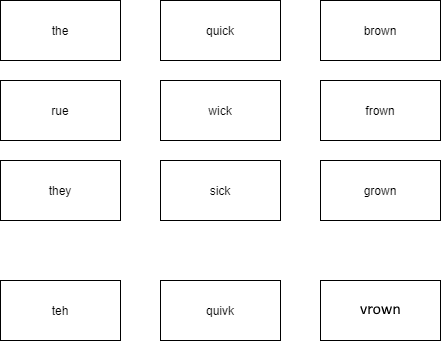

In [94]:
from IPython.display import Image 
pil_img = Image(filename='images\\02.png')
display(pil_img)

And now let's define the transition and emission matrices.
<br><br>
$$\begin{pmatrix} the \\ rue  \\ they  \end{pmatrix},\begin{pmatrix} the\,quick & rue \,quick & they\, quick \\ the\, wick & rue \,wick & they\, wick \\ the\, sick & rue\, sick & they\, sick \end{pmatrix},\begin{pmatrix} quick\,brown & wick \,brown & sick\, brown \\ quick\, frown & wick \,frown & sick\, frown \\ quick\, grown & wick\, grown & sick\, grown \end{pmatrix} = \begin{pmatrix} 0.75  \\ 0.23 \\ 0.27 \end{pmatrix},\begin{pmatrix} 0.45 & 0 & 0 \\ 0.1 & 0 & 0 \\ 0.45 & 0 & 0 \end{pmatrix},\begin{pmatrix} 0.75 & 0 & 0 \\ 0.25 & 0 & 0 \\ 0 & 0 & 0 \end{pmatrix}$$

<br>Note that I picked arbitrary probabilities, i.e. "They wick" is obviously not grammatically correct.  I did not use my bigram data because "brown fox" and "quick brown" are never used in the books I scanned.


$$\begin{pmatrix} the|teh & quick|quivk & brown|vrown \\ rue|teh & wick|quivk & frown|vrown \\ they|teh & sick|quivk & grown|vrown \end{pmatrix} = \begin{pmatrix} 0.55 & 0.6 & 0.33 \\ 0.18 & 0.2 & 0.33 \\ 0.27 & 0.2 & 0.33 \end{pmatrix}$$

Now to solve viterbi. $$argmax_{(h_1:T)}p(h_{1:T}|v_{1:T})$$
<br>We can see that given a distribution of $$p(h_{1:T},v_{1:T}) = p(v_1|h_1)p(h_1)\prod_{t=2}^Tp(v_t|h_t)p(h_t|h_{t-1})$$ the path that gives the highest likelihood is  $$the \rightarrow quick \rightarrow brown$$  which corresponds to a path total of $$(0.55*0.75)+(0.6*0.45)+(0.33*0.75)$$

# A new strategy

What about errors spanning multiple words?  The simple HMM only accomodates typos of a single word at a time.  In the following model we will expand the previous model.  We will also implement the state space search and path finding to obtain a fully functional spell checker.  Note that many ideas and equations were borrowed from [1].

In order to also fix errors spanning multiple words, we must modify the HMM sturcture a few ways.  We must allow hidden states to be null and also assign each hidden state a "type", referring to what kind of correction this state is making. Let's also make a few definitions:

| correction type    | example                              |
|--------------------|--------------------------------------|
| in-word correction | yeserday $\rightarrow$ yesterday       |
| splitting          | feelingsick $\rightarrow$ feeling sick |
| merging            | power point $\rightarrow$ powerpoint   |
| transferring       | cora lreef $\rightarrow$ coral reef|

Here are some graphical examples of the multiple word corrections I'm talking about.

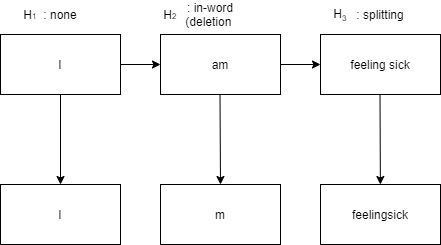

In [95]:
pil_img = Image(filename='images\\03.png')
display(pil_img)

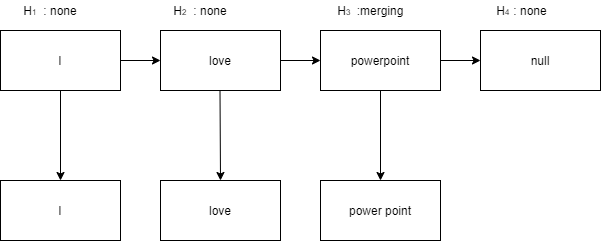

In [96]:
pil_img = Image(filename='images\\04.png')
display(pil_img)

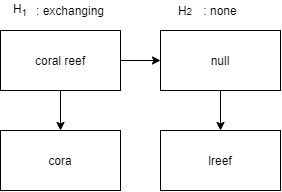

In [97]:
pil_img = Image(filename='images\\05.png')
display(pil_img)

A few more definitions: the query chain is $v_{1:n}$ and each counterfactual hidden state chain is $h_{1:n}$ and the type is denoted as $t_i$.  We must also define a "context" for each member of a state chain $c_i=<h_{i-1},t_{i-1},h_i,t_i,v_{1:n}>$ which contains the previous and current state and type as well as the entire search query.  
<br>
Recall that earlier I built a bigram dataset and a dictionary.  The dictionary contains many valid english words.  The bigram dataset contains many two word phrases and how many times these phrases were seen.
<br><br>
Below I define unscramble(), a process much like the scramble() function I wrote; but it does the exact opposite.  Unscramble() takes a mispelled word and attempts to find the correct word the user meant to type. 

In [8]:
alphabet=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
#this function takes a typo and attempts to find the valid english word that the user meant to type
#in other words it generates all possible hidden states from an observed state
def unscramble(word,iterations):
    result = []
    oldLevel = [word]
    result.append(oldLevel)
    newLevel = []
    trueResult = []
    editDistance = []
    #one iteration is one keystroke of noise
    for j in range(iterations):
        for word in oldLevel:
            #iterate through the word
            for pos1 in range(len(word)-1):
                #pos1 and pos2 are adjacent letters
                pos2 = pos1 + 1
                nearby = neighbors(word[pos2])
                stringList = list(word)
                #swap two neighboring letters
                stringList[pos1],stringList[pos2]=stringList[pos2],stringList[pos1]
                jumbled = "".join(stringList)
                newLevel.append(jumbled)
                #if its a valid word add it to the result
                if jumbled in dictionary and jumbled not in trueResult:
                    trueResult.append(jumbled)
                    editDistance.append(j+1)
                #if the adjacent letters are also neighbors on the keyboard
                if word[pos1] in nearby:
                    stringList2 = list(word)
                    #remove the first adjacent letter
                    stringList2 = stringList2[:pos1]+stringList2[pos2:]
                    jumbled2 = "".join(stringList2)
                    newLevel.append(jumbled2)
                    #if its a valid word add it
                    if jumbled2 in dictionary and jumbled2 not in trueResult:
                        trueResult.append(jumbled2)
                        editDistance.append(j+1)

                #iterate through nearby letters on the keyboard
                for letter in nearby:
                    stringList3 = list(word)
                    #replace the current letter with neighboring letters on the keyboard
                    stringList3[pos2]=letter
                    jumbled3 = "".join(stringList3)
                    newLevel.append(jumbled3)
                    #check if its valid
                    if jumbled3 in dictionary and jumbled3 not in trueResult:
                        trueResult.append(jumbled3)
                        editDistance.append(j+1)
                    stringList4 = list(word)
                    #insert the neighboring letter instead of replacing
                    jumbled4 = "".join(stringList4[:pos2]+[letter]+stringList4[pos2:])
                    newLevel.append(jumbled4)
                    #check again
                    if jumbled4 in dictionary and jumbled4 not in trueResult:
                        trueResult.append(jumbled4)
                        editDistance.append(j+1)
        #proceed to a new iteration of noise
        oldLevel = newLevel
        newLevel = []
        result.append(oldLevel)
    #return the typos and how many iterations of noise produced the typo
    return trueResult,editDistance

In [9]:
#what are the correct forms of the typo "hpoee" within three keystrokes
#return typos and the number of keystrokes required to produce the typo
unscramble("hpoee",3)

(['hope',
  'hoped',
  'hopes',
  'hoe',
  'hole',
  'holed',
  'holes',
  'hoods',
  'hooded',
  'hoofs',
  'hood',
  'hoof',
  'hopped',
  'ohe',
  'hide',
  'hire',
  'hors',
  'horse',
  'howes',
  'how'],
 [2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

We must now briefly define a state space search proces and how this results in proposed hidden states.  This state space search also generates the emission distributions for the HMM!  The function does this by calling unscramble on each word in the query, and then tracking how many edits resulted in the unscrambled word.  We also add sections for multi-word corrections.  These are easy: each split and merge correction only costs one keystroke and exchanging costs two keystrokes.  By keeping track of each edit distance we no longer need to implement the edit distance algorithm.

Let's also iron out the specifics of how emission probability works in the case of multi-word corrections.  For this, we require  a feature-vector function that maps a context and state to a set of feature-vectors.  We will call this -- $e$ -- and it finds dependencies between the search query and the hidden states -- in other words emission.  Here is the feature vector:
$$e_k(h_i,t_i,v_{1:n}),k = 1...d'$$
Where k is the variant of the feature-vector and d' is the dimensions of the feature-vector.  Now to define the feature-vector functions, $e_1,e_2,e_3,e_4$:

| $t_i,v_i\in dic$     |&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $e_1(h_i,t_i,v_{1:n})$ | reason |
|--------------------|----------------------------------------|-|
| in-word $\land$ false     | $log(p_{dist}(h_i,v_i))$                      |if the user made an in-word typo the resulting mispelling will not be a valid english word|
| $\neg$in-word $\lor$ true     | 0                      |this is not a in-word typo|

<br>

| $t_i,v_i\in dic$|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $e_2(h_i,t_i,v_{1:n})$ | reason |
|--------------------|----------------------------------------|-|
| split $\land$ false     | $log(p_{dist}(h_i,v_i))$                      |if the user accidentally combined two words the resulting mispelling will not be a valid english word|
| $\neg$split $\lor$ true     | 0                      |this is not a splitting typo|

<br>

| $t_i,v_i\in dic$|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   $e_3(h_i,t_i,v_{1:n})$ | reason |
|------------------|--------------------------------------|-|
| merge $\land$ true*     | $log(p_{dist}(h_i,v_i+"\,"+v_{i+1}))$                      |* if the user accidentally split a single word then the joined phrase will be a valid english word. <br>  Also, run edit distance on the current query word joined with a space and the next query word.  <br> This is okay since the next hidden state will be null|
| $\neg$merge $\lor$ false     | 0                      |this is not a merging typo|

| $t_i,v_i\in dic$|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $e_4(h_i,t_i,v_{1:n})$ | reason |
|------------------|-------------------------------------|-|
| exchange $\land$ false     | $log(p_{dist}(h_i,v_i+"\,"+v_{i+1}))$                      |if the user mistyped spacepress, the two resulting words <br> will not be valid english words.  Also run edit distance on the current query word and <br>the next query word.  This is okay because the next hidden state will be null.|
| $\neg$exchange $\lor$ true     | 0                      |this is not an exchanging typo|


Now that we know the specifics, we can put this process into python.

In [10]:
#helper function for adding 
def add(a,b,c):
    if len(a[b]) == 0:
        a[b] = [c]
    else:
        a[b].append(c)
#generate hidden states from a string query
def genStates(query,iterations):
    #split on spaces and make an array
    listQuery = query.split(" ")
    hiddenStates = [[]]*len(listQuery)    
    hiddenTypes = [[]]*len(listQuery) 
    editDistance = [[]]*len(listQuery)
    #for observed typo
    for index, i in enumerate(listQuery):
        #if the observed state is a valid word
        #add the word to the HMM and label it as 'no correction' with an edit distance of 0
        if i in dictionary:
            add(hiddenStates,index,i)
            add(hiddenTypes,index,"no correction")
            add(editDistance,index,0)
        #if the observed word is not a valid word
        if i not in dictionary:
            #unscramble the word 
            corrected = unscramble(i,iterations)
            #add the unscrambled words we found to the HMM
            #also add the type "in-word" and the edit distance
            for jindex,j in enumerate(corrected[0]):
                add(hiddenStates,index,j)
                add(hiddenTypes,index,"in-word")
                add(editDistance,index,corrected[1][jindex])
            #try splitting the word on each index
            #if the two resulting words are both valid words, add the phrase to the HMM
            #indicate the type "splitting" and the edit distance is 1
            for j in range(1,len(i)): #splitting
                left = i[:j]
                right = i[j:]
                if left in dictionary and right in dictionary:
                    add(hiddenStates,index,left+ " "+ right)
                    add(hiddenTypes,index,"splitting")
                    add(editDistance,index,1)
        #for a merging/exchange type, combine this observed state with the next observed state
        #if the result is a valid word, add the phrase to the HMM with type and edit distance 
        #also remember to add None to the next level in the HMM
        if index != len(listQuery)-1:
                nextWord = listQuery[index+1]
                #exchanging type
                for j in range(1,3):
                    if i+nextWord[:j] in dictionary and nextWord[j:] in dictionary:
                        add(hiddenStates,index,i+nextWord[:j]+" "+nextWord[j:])      
                        add(hiddenStates,index+1,None)
                        add(hiddenTypes,index+1,None)
                        add(editDistance,index+1,None)
                        add(hiddenTypes,index,"transferring")
                        add(editDistance,index,2)
                #merging type
                if i+nextWord in dictionary:
                    add(hiddenStates,index,i+listQuery[index+1])
                    add(hiddenStates,index+1,None)
                    add(hiddenTypes,index+1,None)
                    add(editDistance,index+1,None)
                    add(hiddenTypes,index,"merging")
                    add(editDistance,index,1)
        #if we couldn't find a state, just add the original word and indicate we couldn't find a valid state
        if(len(hiddenStates[index])==0):
            add(hiddenStates,index,i)
            add(hiddenTypes,index,"not-found")
            add(editDistance,index,np.nan)
    return(hiddenStates,hiddenTypes,editDistance)    

In [11]:
#define a query with typos
#note that this query comes from the training material
query = "he carriedhis fat pau nch"
#print the hidden states, their types, and edit distances
hiddenStates, hiddenTypes, editDistance = genStates(query,1)
print(hiddenStates,"\n\n",hiddenTypes,"\n\n",editDistance)

[['he'], ['carried his'], ['fat'], ['pay', 'pah', 'paunch'], [None]] 

 [['no correction'], ['splitting'], ['no correction'], ['in-word', 'in-word', 'merging'], [None]] 

 [[0], [1], [0], [1, 1, 1], [None]]


Another feature vector function -- $tr$-- will find dependencies between past and current states and types, this measures transition:
$$tr_j(h_{i-1},t_{i-1},h_i,t_i),j = 1...d $$
Where j is the variants of the feature-vector and d is the dimensions of the feature-vector.  Now to define the feature-vector function $tr_1$:

$$tr_1(h_{i-1},t_{i-1},h_i,t_i) = log(p_t(h_i|h_{i-1},t_{i-1},t_i))$$
<br>
Whre $p_t(h_i|h_{i-1},t_{i-1},t_i)$ measures the transition probability.  Before this was simply 
$$p_{simple}(h_{i-1},h_{i}) = \frac{count(h_{i-1} + "\," + h_i)}{total \, count}$$
Where total count is the sum of each bi-gram count in transition $h_{i-1} \rightarrow h_{i}$. But the addition of multi-word correction means we must define a new function.

| $t_{i-1},t_i$     | $p_t(h_i\mid h_{i-1},t_{i-1},t_i)$  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;         | reason |
|--------------------|----------------------------------------|-|
| merge or exchange, null        | 1                                      |If the last state merged two words or transferred letters, the current state must be empty|
| null, any          | $p_t(h_i\mid h_{i-2},merge/exchange,t_i)$ |If the last state is null, instead consider the state before it which is inevitably a merge/exchange type|
| any non-null non-split non-exchange type, split            | $\frac{p_{simple}(h_{i-1},h_{i}[0])+p_{simple}(h_i[0],h_i[1])}{2}$|since state $h_i$ is two words we first take the simple popularity of the bigram of $h_{i-1}$ and the first word of $h_{i}$ added to the simple popularity of the biagram of the first and second word of $h_{i}$ and normalize by dividing by two|
| split or exchange, any non-null and non-split non-exchange type            | $p_{simple}(h_{i-1}[1],h_{i})$|since state $h_{i-1}$ is two words we take the simple popularity of the bi-gram of $h_{i-1}[1]$ and $h_i$.  Note that we do not repeat the bi-gram popularity of $h_{i-1}$ as we already did this above |
| split or exchange, split or exchange           | $\frac{p_{simple}(h_{i-1}[1],h_{i}[0])+p_{simple}(h_i[0],h_i[1])}{2}$|since both states are two words in length, use the words that make up those phrases|
| otherwise           | $p_{simple}(h_{i-1},h_{i}$)||

Let's go ahead and put this into python.  

In [12]:
#checkBeforeAdd stops the key not found error
def checkBeforeAdd(d,key,phrase,bigram):
    if phrase in bigram:
        d[key] = bigram[phrase]
    else:
        d[key] = 0
def getTransitions(hiddenStates,hiddenTypes):
    #we'll store transitions in a dictionary
    #i,j:k,l is the key format, describing transition from i,j-th hidden state to the k,l-th hidden state
    d = {}
    #iterate through each transition in the hidden states
    for i in range(len(hiddenStates)-1):
        for j in range(len(hiddenStates[i])):
            for k in range(len(hiddenStates[i+1])):
                firstState = hiddenStates[i][j]
                secondState = hiddenStates[i+1][k]
                firstType = hiddenTypes[i][j]
                secondType = hiddenTypes[i+1][k]
                key = str(i)+","+str(j)+":"+str(i+1)+","+str(k)
                #if the first state is merging or exchanging the transition prob is np.inf
                #in other words merge must lead to null
                if (firstType == "merging" or firstType =="transferring") and secondState == None:
                    d[key] = np.inf
                #if the first state is null then the state before the first state must be a merging/exchanging type
                #get the state one level behind that is a merging type
                #use the "one level behind" state instead of the actual first state
                elif firstState == None:
                    if secondState == None:
                        d[key] = 0
                    else:
                        if "merging" in hiddenTypes[i-1]:
                            realFirstState = hiddenStates[i-1][hiddenTypes[i-1].index("merging")]
                        #since exchanging is two words not one we split and index
                        if "transferring" in hiddenTypes[i-1]:
                            realFirstState = hiddenStates[i-1][hiddenTypes[i-1].index("transferring")].split(" ")[1]
                        if secondType != "splitting":
                            checkBeforeAdd(d,key,realFirstState+" "+secondState,bigram)
                        #if the second state is splitting or transferring it will be two words and we need to split
                        #then run simple prob on the individual words
                        if secondType == "splitting" or secondType == "transferring":
                            words = secondState.split(" ")
                            if realFirstState + " " + words[0] in bigram and words[0] + " " + words[1] in bigram:
                                d[key] = 0.5 * (bigram[realFirstState + " " +words[0]]+bigram[words[0]+ " "+words[1]])
                            else:
                                d[key] = 0
                #if the second state is splitting/exchanging type then it's a phrase and not a single word!
                #we take the count of the first state plus the first word of the second state
                #and the count of the first word of the second state plus the second word of the second state
                #and we normalize this value
                elif (firstState != None and firstType != "splitting" and firstType != "transferring") and (secondType == "transferring" or secondType == "splitting"):
                    words = secondState.split(" ")
                    if firstState + " " + words[0] in bigram and words[0] + " " + words[1] in bigram:
                        d[key] = 0.5 * (bigram[firstState + " " +words[0]]+bigram[words[0]+ " "+words[1]])
                    else:
                        d[key] = 0
                #if the first state is splitting/exchanging type and the second state is not splitting/exchanging--
                #--type we do something similar to above
                #take the count of the second word of the first state plus the second state
                elif (firstType == "splitting" or firstType == "transferring") and (secondType != None and secondType != "splitting" and secondType != "transferring"):
                    checkBeforeAdd(d,key,firstState.split(" ")[1]+" "+secondState,bigram)
                #handle two adjacent splitting/exchanging types
                elif (firstType == "splitting" or firstType == "transferring") and (secondType == "transferring" or secondType == "splitting"):
                    words1 = firstState.split(" ")
                    words2 = secondState.split(" ")
                    if words[1] + " " + words2[0] in bigram and words2[0] + " " + words2[1] in bigram:
                        d[key] = 0.5 * (bigram[words1[1] + " " +words2[0]]+bigram[words2[0]+ " "+words2[1]])
                    else:
                        d[key] = 0
                #if the first state and second state are non null, find the counts of this phrase
                elif hiddenStates[i][j] != None and hiddenStates[i+1][k] != None:
                    checkBeforeAdd(d,key,firstState+" "+secondState,bigram)
                #else enter counts as zero
                else:
                    d[key] = 0
    return d

In [13]:
#get the complete transition distributions
transitions = getTransitions(hiddenStates,hiddenTypes)
print(transitions)

{'0,0:1,0': 9.0, '1,0:2,0': 3, '2,0:3,0': 0, '2,0:3,1': 0, '2,0:3,2': 1, '3,0:4,0': 0, '3,1:4,0': 0, '3,2:4,0': inf}


<br>
At this point we have a method for creating a state space, a method for mapping the state space to a generalized HMM, a method for finding transition, and a method for finding emission.  All that is left is to put the pieces together; we must score each feature-vector path and then find the path which optimizes feature-vector score.  Here's how scoring is done:
$$score(h_{1:n},t_{1:n}) = \sum_{i=1}^n\sum_{j=1}^dc_{j}t_j(h_{i-1},t_{i-1},h_i,t_i)+\sum_{i=1}^n\sum_{k=1}^d'm_{k}e_k(h_i,t_i,v_{1:n})$$
Here the c and m are constants indicating the weight of each feature-vector, and this is the reason for using feature-vectors.  The model can give varying weights to different kinds of corrections -- and weights for emission vs. transition.  For example, if statistically speaking a splitting error is the most likely error, m might look like this:
$$\begin{pmatrix} 0.1 & 0.8 & 0.1 \end{pmatrix}$$
However, without the access to good data on typos made with a keyboard it's best to set each weight to 1.
<br>
Then, using viterbi again gives us the most likely hidden state sequence:
$$argmax_{h_{1:n},t_{1:n}}score(h_{1:n},t_{1:n})$$
Here's how I implemented viterbi in python for this HMM.  Note that I used pseudocode and a simplified example from [2] as reference for my implementation:

In [14]:
#a helper function
#this scores each edit distance by raising the distance to ^-1.  This way more edits is less likely
#also deals with None caused by a multi-word correction and np.nan caused by failing to find a correction
def distToProb(dist):
    if dist != None:    
        if np.isnan(dist):
            return 0
        return (dist+1) ** -1
    return 1
#np.inf means a transition from exchange/merge to a NULL.  We used np.inf to show that exchange/merge MUST be followed by null
#In reality, this transition preserves cumulative probability -- the transition probability is not truly infinite
def checkTrans(trans):
    if trans == np.inf:
        return 1
    return trans
#viterbi alignment
def getPath(query,hiddenStates,transitions,editDistance,hiddenTypes):
    #we use a dictionary to hold each hop
    v = [{}]
    #do calculations for the first set of states
    for index,state in enumerate(hiddenStates[0]):
        v[0][state] = {'prob':distToProb(editDistance[0][index]),'prev':None}
    #for the rest of the hidden states
    for t in range(1,len(hiddenStates)):
        v.append({})
        #iterate through the curent states and the states for the previous hop
        for index, state in enumerate(hiddenStates[t]):
            #this is a placeholder to start initiate maxTrProb and prevStateSelected
            maxTrProb = v[t-1][hiddenStates[t-1][0]]["prob"]*checkTrans(transitions[str(t-1)+",0:"+str(t)+","+str(index)])
            prevStateSelected = hiddenStates[t-1][0]
            for jindex, prevState in enumerate(hiddenStates[t-1][1:]):
                trProb = v[t-1][prevState]["prob"]*checkTrans(transitions[str(t-1)+","+str(jindex+1)+":"+str(t)+","+str(index)])   
                #find the max transition from the previous hop to the current set of states
                if trProb > maxTrProb:
                    maxTrProb = trProb
                    prevStateSelected = prevState
            #evaluate the cumulative likelihood and mark this number as well as the hop that produced it
            maxProb = maxTrProb * distToProb(editDistance[t][index])
            #extra measures to compensate for a small dictionary and bigram datasest
            #if a phrase transition or word emission cannot be found in the bigram/dictionary, the cumulative probability 
            #--for a path will get stuck at zero.  Once this happens all paths become equal no matter which one is more correct
            if maxProb == 0.0:
                maxProb = 0.1
            v[t][state] = {"prob":maxProb,"prev":prevStateSelected}
    optimal = []
    maxProb = 0.0
    previous = None
    bestState = None
    #start at the end and find the highest score
    for state,data in v[-1].items():
        if data["prob"] >= maxProb:
            maxProb = data["prob"]
            bestState = state
    optimal.append(bestState)
    previous = bestState
    #iterate backwards to produce the path
    for t in range(len(v)-2,-1,-1):
        optimal.insert(0,v[t+1][previous]["prev"])
        previous = v[t+1][previous]["prev"]
    print(optimal)

In [15]:
#finally, use viterbi to find the most likely path, and therefore the corrected query
getPath(query, hiddenStates, transitions, editDistance,hiddenTypes)       

['he', 'carried his', 'fat', 'paunch', None]


For testing, I'm going to open a book by Joseph Conrad and type quickly.  Three of the books trained on were written by Joseph Conrad, but this book was not part of the training data.  I would love to use the books that were trained on but that doesn't exactly prove that the model is learning anything.

In [86]:
query1 = "sometimes it was mrs verloc who would apear at the call of the cracked bell winnie verloc was a yougn womean with a full bust in a tight bodice and wt hbroad hips her hair was very tidy steady eyed like her husband she preserved an air of unfathomable indifference bhind the ramprt of thecounter then the customer of comparitively tendre years would get suddenly disocnverted at having to deal wth a omn and with rage in his heart would proffer a request for a bolte or marking ink reatil value sixpence which once outside hw would drop stealithy into the gutter"
query2 = "it clatted and at that signal through the sudsty glass dor behind the painted deal counter mr verloc would issue hastily fro mthe parlour at the back his eyes were naturally heavy he had an ir of having walowed fully dressed all day on an unamde bed another man wuld have felt such an appearance a distinct dsicavnatage in a commercial transaction of athe retail order much ddpends on the sellers' engagin and amiable aspect"

In [89]:
start = timeit.default_timer()
hiddenStates, hiddenTypes, editDistance = genStates(query1,2)
transitions = getTransitions(hiddenStates,hiddenTypes)
getPath(query, hiddenStates, transitions, editDistance,hiddenTypes)   
stop = timeit.default_timer()
print('Runtime: ', stop - start)  

['sometimes', 'it', 'was', 'mrs', 'verloc', 'who', 'would', 'appear', 'at', 'the', 'call', 'of', 'the', 'cracked', 'bell', 'winkie', 'verloc', 'was', 'a', 'young', 'woman', 'with', 'a', 'full', 'bust', 'in', 'a', 'tight', 'bodice', 'and', 'ts', 'broad', 'hips', 'her', 'hair', 'was', 'very', 'tidy', 'steady', 'eyed', 'like', 'her', 'husbands he', None, 'preserved', 'an', 'air', 'of', 'unfathomable', 'indifference', 'hind', 'the', 'ramprt', 'of', 'the counter', 'then', 'the', 'customer', 'of', 'comparitively', 'tender', 'years', 'would', 'get', 'suddenly', 'disconcerted', 'at', 'having', 'to', 'deal', 'why', 'a', 'on', 'and', 'with', 'rage', 'in', 'his', 'heart', 'would', 'proffer', 'a', 'request', 'for', 'a', 'bite', 'or', 'marking', 'ink', 'retail', 'value', 'sixpence', 'which', 'once', 'outside', 'he', 'would', 'drop', 'stealthy', 'into', 'the', 'gutter']
Runtime:  0.37643129999923985


In [90]:
start = timeit.default_timer()
hiddenStates, hiddenTypes, editDistance = genStates(query2,2)
transitions = getTransitions(hiddenStates,hiddenTypes)
getPath(query, hiddenStates, transitions, editDistance,hiddenTypes)   
stop = timeit.default_timer()
print('Runtime: ', stop - start)  

['it', 'clatter', 'and', 'at', 'that', 'signal', 'through', 'the', 'dusty', 'glass', 'door', 'behind', 'the', 'painted', 'deal', 'counter', 'mr', 'verloc', 'would', 'issue', 'hastily', 'from the', None, 'parlour', 'at', 'the', 'back', 'his', 'eyes', 'were', 'naturally', 'heavy', 'he', 'had', 'an', 'is', 'of', 'having', 'allowed', 'fully', 'dressed', 'all', 'day', 'on', 'an', 'unamde', 'bed', 'another', 'man', 'would', 'have', 'felt', 'such', 'an', 'appearance', 'a', 'distinct', 'dsicavnatage', 'in', 'a', 'commercial', 'transaction', 'of', 'tame', 'retail', 'order', 'much', 'depends', 'on', 'the', "sellers '", 'engaging', 'and', 'amiable', 'aspect']
Runtime:  0.25895399999717483


In [19]:
start = timeit.default_timer()
hiddenStates, hiddenTypes, editDistance = genStates("this nigga hasa",2)
transitions = getTransitions(hiddenStates,hiddenTypes)
getPath(query, hiddenStates, transitions, editDistance,hiddenTypes)   
stop = timeit.default_timer()
print('Runtime: ', stop - start)  

['this', 'nina', 'has a']
Runtime:  0.01854120000001558


And there we have it, a generalized HMM for spell checking.  Here are some things this HMM model *cannot* do:  

Firstly, and most importantly, the function for generating hidden states is an extremely naive process concisting of a loop and my idea of what causes typos.  Clearly this worked decently well, but not anywhere close to perfectly.  Some typing errors like "dsicavnatage" could not be unscrambled by a naive process. 

Also, the state space function -- the unscramble function really -- runs in $n^2$ time, and must run for each word.  For this reason, corrections with lots of noise will take a "long" time to correct.  But with two levels of noise, the queries completed very quickly. Users expect spell checkers to work at the snap of a finger -- and they must do this to be useful to the user -- and this process does do that.  

Secondly, this HMM is fairly bare bones.  It does not process text or convert the path back to text with punctuation and capitlization -- I just typed everything in lowercase and without punctuation.  I also allowed the state space generation process to ignore valid English words when in reality the user may misuse a word or type a valid word when they meant to type another, i.e. "effect of coronavirus" vs. "affect of coronavirus."  

# Closing thoughts
Let's close with a few improvements that could be made.  The first improvement has to do with data, and the second improvement has to do with finding the state space.   
<br>
The data that I used was all generated from free online resources.  I scrolled through gutenberg and tried to find as many recent books as I could, and I found 11.  It is now very clear that number is way too small; I think I would need thousands of books to get good results.  If I was to make this project better I would write a script do download many books. In addition, a good n-gram dataset should be specific: data compiled from queries on a specific service will always be more accurate for correcting future queries on that service.

And as for finding the state space, I should make it clear that my HMM will not correct mixed multi-word and in-word typos:

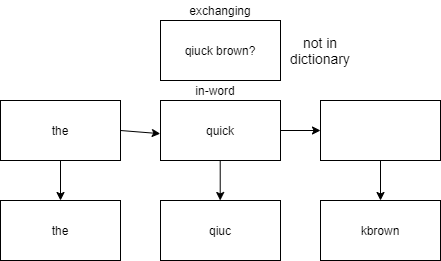

In [98]:
pil_img = Image(filename='images\\06.png')
display(pil_img)

The following modification to generate states would work though:

    for word in query:
        generate states for in-word corrections
        for each index in word:
            split the word on index
            if left fragment + right fragment in dictionary:
                add to HMM
            else if unscramble(left fragment) + unscramble(right fragment):
                add to HMM
        if word + next word in dictionary:
            add to HMM
        if unscramble(word) + unscramble(next word) in dictionary:
            add to HMM

And seeing as keeping the data in sets and dictionaries allows for a very good runtime, the above code would actually work despite being signficantly slower.  If I had more time I could've actually implemented this.  However, how correct would these states even be?

Software companies that use a website with a search feature -- amazon, youtube, etsy -- will track consecutive searches (and probably many other things as well).  If a user makes a typo and is therefore unable to find what they're looking for, they will correct their query and search again. These queries are assembled into a data set, which can be used to train a deep learning network to generate hidden states.  This process would generate states based on what typos users actually make.  Clearly this is far superior.

On a less important note, we could also use this data for a new heuristic for typos and to find the weights for each feature vector.  

# References
[1] A Generalized Hidden Markov Model with Discriminative Training for Query Spelling Correction http://times.cs.uiuc.edu/czhai/pub/sigir12-spelling.pdf

[2] Viterbi Algorithm https://en.wikipedia.org/wiki/Viterbi_algorithm